# Comets

## Data from MPC

In [1]:
import sqlite3
import urllib
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import spiceypy as sp
from astropy import units as u
from astropy.table import QTable
from astropy.time import Time
from astroquery.jplhorizons import Horizons
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('dark_background')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix',
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5,
    'xtick.top': True, 'ytick.right': True,
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})

warnings.filterwarnings('ignore', append=True)

def download_file(dl_path, dl_url):
    """ Download files from the Internet.

    Parameters
    ----------
    dl_path : str
        Download path on the local machine, relative to this function.
    dl_url : str
        Download url of the requested file.
    """

    # Make directory if it does not exist
    dl_path = Path(dl_path)
    dl_path.mkdir(parents=True, exist_ok=True)
    # Get the file name from the url
    file_name = dl_url.split('/')[-1]

    # If the file is not present in the download directory -> download it
    if not (dl_path/file_name).exists():
        # Download the file with the urllib  package
        urllib.request.urlretrieve(dl_url, dl_path/file_name)

# Load the SPICE kernel meta file
sp.furnsh('kernel_meta.txt')

# The comet data from the Minor Planet Center
download_file(
    'raw_data/',
    'https://www.minorplanetcenter.net/Extended_Files/cometels.json.gz'
)

_, GM_SUN = sp.bodvcd(bodyid=10, item='GM', maxn=1)
GM_SUN = GM_SUN[0]

NOW_UTC = Time.now().utc
NOW_ET = sp.utc2et(NOW_UTC.strftime('%Y-%m-%dT%H:%M:%S'))
print(f"{NOW_UTC} (in SPICE ET: {NOW_ET})")

c_df = pd.read_json('raw_data/cometels.json.gz', compression='gzip')
c_df.tail()

2023-11-23 10:59:33.682708 (in SPICE ET: 754009242.1828953)


,Orbit_type,Provisional_packed_desig,Year_of_perihelion,Month_of_perihelion,Day_of_perihelion,Perihelion_dist,e,Peri,Node,i,Epoch_year,Epoch_month,Epoch_day,H,G,Designation_and_name,Ref,Comet_num
1089,P,NaN,2025,12,8.8163,3.005487,0.307438,43.5395,178.9645,20.1742,2023.0,11.0,22.0,13.5,4.0,469P/PANSTARRS,MPEC 2023,469.0
1090,P,NaN,2023,12,18.2515,2.728714,0.390381,152.0501,246.1830,8.8387,2023.0,11.0,22.0,15.5,4.0,470P/PANSTARRS,MPEC 2023,470.0
1091,P,NaN,2023,12,20.2949,2.123404,0.627962,94.9585,283.3426,4.7909,2023.0,11.0,22.0,12.0,4.0,471P,MPEC 2023,471.0
1092,I,NaN,2017,9,9.4886,0.255240,1.199252,241.6845,24.5997,122.6778,2017.0,9.0,4.0,23.0,2.0,1I/`Oumuamua,MPC107687,1.0
1093,I,NaN,2019,12,8.5548,2.006548,3.356633,209.1251,308.1480,44.0527,2019.0,12.0,23.0,11.0,4.0,2I/Borisov,MPEC 2023,2.0


Add Necessary info to the df:

In [2]:
# First we parse the date and time information. The dataset contains two
# time related information: the date-time of the last perihelion passage and
# another variable called Epoch. However, "epoch" is not related to the mean
# anomaly related epoch and represents other time information in this case.
#
# For our "actual" Epoch case we need to create a UTC time string based on the
# date and time of the last perihelion passage (the time corresponds to a mean
# anomaly of 0 degrees). The Day is given in DAY.FRACTION_OF_DAY. We extract
# only the day
times_utc = []
times_et = []
day = c_df["Day_of_perihelion"].astype(int)
fracday = c_df["Day_of_perihelion"].values % 1

for i, row in c_df.iterrows():
    datetime = Time("{}-{}-{}".format(row["Year_of_perihelion"], row["Month_of_perihelion"], day[i]),
                    format='iso',
                    scale='utc'
                    ) + fracday[i]*u.day
    times_utc.append(datetime.iso)
    times_et.append(sp.utc2et(datetime.iso))
c_df["epoch_utc"] = times_utc
c_df["epoch_et"] = times_et

c_df['a'] = c_df['Perihelion_dist'] / (1 - c_df['e'])
c_df['Q'] = c_df["a"]*(1 + c_df["e"])
_open = c_df["e"] > 1
c_df["a"][_open] = np.nan
c_df["Q"][_open] = np.nan

## Hale-Bopp

Extract HB:

In [3]:
# Extract Hale-Bopp
hb = c_df.loc[c_df['Designation_and_name'].str.contains('Hale-Bopp')].to_records()

# Set an array with orbital elements in a required format for the conics
# function. Note: the mean anomaly is 0 degrees and will be set as a default
# value in the SQLite database
elt_hb = [
    sp.convrt(hb['Perihelion_dist'][0], 'AU', 'km'),
    hb['e'][0],
    np.deg2rad(hb['i']),
    np.deg2rad(hb['Node']),
    np.deg2rad(hb['Peri']),
    0.0,
    hb['epoch_et'],
    GM_SUN
]

vec_hb = sp.conics(elt_hb, NOW_ET)

hb_hori = QTable(Horizons(id='Hale-Bopp', epochs=NOW_UTC.jd, id_type='id').vectors())

print(f" x, y, z   [MPC & SPICE]: {sp.convrt(vec_hb[0], 'km', 'au')}, {sp.convrt(vec_hb[1], 'km', 'au')}, {sp.convrt(vec_hb[2], 'km', 'au')}")
print(f" x, y, z    [HORIZONS]  : {hb_hori['x'][0]}, {hb_hori['y'][0]}, {hb_hori['z'][0]}")
print(f"vx, vy, vz [MPC & SPICE]: {vec_hb[3]}, {vec_hb[4]}, {vec_hb[5]}")
print(f"vx, vy, vz  [HORIZONS]  : {hb_hori['vx'][0].to_value('km/s')}, {hb_hori['vy'][0].to_value('km/s')}, {hb_hori['vz'][0].to_value('km/s')}")

 x, y, z   [MPC & SPICE]: 4.0161712354914965, -20.301323768426357, -43.13542816219059
 x, y, z    [HORIZONS]  : 4.069610202635829 AU, -20.44397982666949 AU, -43.06713371970633 AU
vx, vy, vz [MPC & SPICE]: 0.6343979039371572, -3.1064475134898726, -4.693091939003875
vx, vy, vz  [HORIZONS]  : 0.6371657294813312, -3.1244424341255317, -4.681673512983235


Add to DB:

In [4]:
cometdir = Path('../_databases/_comets/')
cometdir.mkdir(parents=True, exist_ok=True)

# Create / Connect to a comet database and set the cursor
con = sqlite3.connect(cometdir/'comets.db')
cur = con.cursor()

# Create (if not existing) a comets' main table, where miscellaneous
# parameters are stored
cur.execute('CREATE TABLE IF NOT EXISTS ' \
            'comets_main(NAME TEXT PRIMARY KEY, ' \
                        'ORBIT_TYPE TEXT, ' \
                        'PERIHELION_AU REAL, ' \
                        'SEMI_MAJOR_AXIS_AU REAL, ' \
                        'APHELION_AU REAL, ' \
                        'ECCENTRICITY REAL, ' \
                        'INCLINATION_DEG REAL, ' \
                        'ARG_OF_PERIH_DEG REAL, ' \
                        'LONG_OF_ASC_NODE_DEG REAL, ' \
                        'MEAN_ANOMALY_DEG REAL DEFAULT 0.0, ' \
                        'EPOCH_UTC TEXT, ' \
                        'EPOCH_ET REAL, ' \
                        'ABSOLUTE_MAGNITUDE REAL, ' \
                        'SLOPE_PARAMETER REAL'
                        ')')

# Insert the data
cur.executemany('INSERT OR REPLACE INTO ' \
                'comets_main(NAME, ' \
                            'ORBIT_TYPE, ' \
                            'PERIHELION_AU, ' \
                            'SEMI_MAJOR_AXIS_AU, ' \
                            'APHELION_AU, ' \
                            'ECCENTRICITY, ' \
                            'INCLINATION_DEG, ' \
                            'ARG_OF_PERIH_DEG, ' \
                            'LONG_OF_ASC_NODE_DEG, ' \
                            'EPOCH_UTC, ' \
                            'EPOCH_ET, ' \
                            'ABSOLUTE_MAGNITUDE, ' \
                            'SLOPE_PARAMETER'
                            ') ' \
                'VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)', \
                c_df[['Designation_and_name', \
                      'Orbit_type', \
                      'Perihelion_dist', \
                      'a', \
                      'Q', \
                      'e', \
                      'i', \
                      'Peri', \
                      'Node', \
                      'epoch_utc', \
                      'epoch_et', \
                      'H', \
                      'G']].values)

# Commit
con.commit()

# Close the database. The database shall be the fundament for the next
# tutorial sessions
con.close()

## Using DB

In [5]:
con = sqlite3.connect(cometdir/'comets.db')
df_p = pd.read_sql_query("SELECT APHELION_AU, INCLINATION_DEG FROM comets_main WHERE ORBIT_TYPE='P'", con)
df_c = pd.read_sql_query("SELECT APHELION_AU, INCLINATION_DEG, ECCENTRICITY FROM comets_main WHERE ORBIT_TYPE='C'", con)
print("P-types")
df_p.describe()

P-types


,APHELION_AU,INCLINATION_DEG
count,795.000000,795.000000
mean,7.514919,15.299683
std,5.952777,15.800642
min,2.442941,0.231400
25%,5.184882,7.901700
50%,5.721530,11.393000
75%,8.682299,18.223000
max,100.161929,172.546800


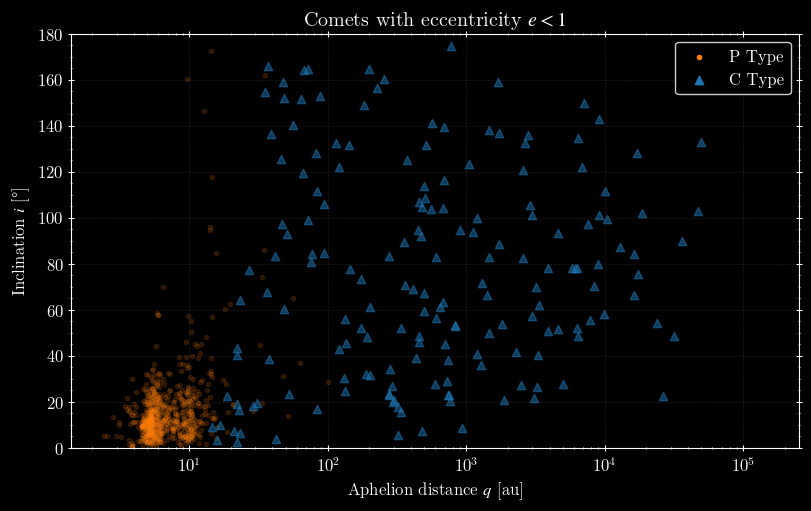

In [6]:
# Set a figure with a certain figure size
fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="constrained", gridspec_kw=None, sharex=False, sharey=False)

# Scatter plot of the P type comet inclination vs. the aphelion
ax.scatter(df_p['APHELION_AU'], df_p['INCLINATION_DEG'],
           marker='.', color='tab:orange', alpha=0.15, label='P Type')

# Scatter plot of the C type comet inclination vs. the aphelion (consider
# only the bound orbits!)
m_e1 = df_c['ECCENTRICITY'] < 1
ax.scatter(df_c[m_e1]['APHELION_AU'], df_c[m_e1]['INCLINATION_DEG'],
           marker='^', color='tab:blue', alpha=0.5, label='C Type')


ax.set(
    title='Comets with eccentricity $e<1$',
    xlabel='Aphelion distance $q$ [au]',
    ylabel='Inclination $i$ [°]',
    xscale='log',
    ylim=(0, 180)
)

# Set a grid for better readability
ax.grid(axis='both', linestyle='dashed', alpha=0.2)

# Now we set a legend. However, the marker opacity in the legend has the
# same value as in the plot. A value of 0.1 would be difficult to see ...
leg = ax.legend(fancybox=True, loc='upper right', framealpha=1)

# ... thus, we set the markers' opacity to 1 with this small code
for lh in leg.legend_handles:
    lh.set_alpha(1)

# Save the plot in high quality
plt.savefig('comets_scatter_plot_Q_i.png', dpi=300)

In [17]:
df_all = pd.read_sql_query("SELECT APHELION_AU, INCLINATION_DEG, ECCENTRICITY, ORBIT_TYPE FROM comets_main", con)
df_all = df_all.loc[df_all['ECCENTRICITY'] < 1].reset_index(drop=True).copy()
df_pc = df_all.loc[df_all['ORBIT_TYPE'].isin(['P', 'C'])].reset_index(drop=True).copy()
df_all.head()

,APHELION_AU,INCLINATION_DEG,ECCENTRICITY,ORBIT_TYPE
0,5.045096,8.7160,0.852140,D
1,4.845850,9.3070,0.571218,D
2,5.215428,10.9262,0.468356,D
3,6.480013,1.4229,0.693883,D
4,6.056831,13.5231,0.626819,D


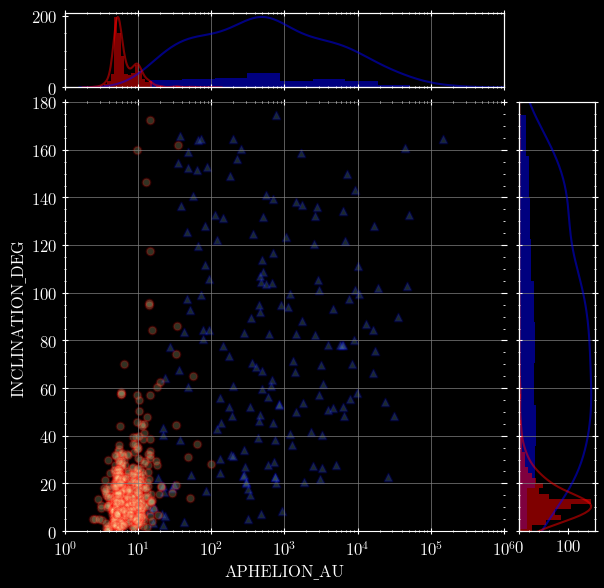

In [61]:
import seaborn as sns

g = sns.JointGrid(xlim=(1, 1.e+6), ylim=(0, 180))
xc, yc = df_c['APHELION_AU'], df_c['INCLINATION_DEG']
xp, yp = df_p['APHELION_AU'], df_p['INCLINATION_DEG']
# Set a log scaling on the y axis
g.ax_joint.set(xscale="log")

for x, y, c, m in zip([xc, xp], [yc, yp], "br", "^o"):
    sns.scatterplot(x=x, y=y, edgecolor=c, marker=m, alpha=0.2, s=30, linewidth=1.5, ax=g.ax_joint)
    sns.histplot(x=x, color=c, fill=True, alpha=0.5, linewidth=0, ax=g.ax_marg_x)
    sns.histplot(y=y, color=c, fill=True, alpha=0.5, linewidth=0, ax=g.ax_marg_y)
    axx2 = g.ax_marg_x.twinx()
    axy2 = g.ax_marg_y.twiny()
    axx2.yaxis.set_ticks([])
    axy2.xaxis.set_ticks([])
    sns.kdeplot(x=x, linewidth=1.5, ax=axx2, color=c, alpha=0.5)
    sns.kdeplot(y=y, linewidth=1.5, ax=axy2, color=c, alpha=0.5)

plt.savefig('comets_kde_plot_Q_i.png', dpi=300)